<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Augmentation/Analysis" data-toc-modified-id="Data-Augmentation/Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Augmentation/Analysis</a></span></li><li><span><a href="#Dataloader-creation-and-test" data-toc-modified-id="Dataloader-creation-and-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataloader creation and test</a></span></li><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model creation</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Model-Testing" data-toc-modified-id="Model-Testing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model Testing</a></span></li></ul></li></ul></div>

**GET DATA**

Summary of this notebook: ...

Definition of Done: ...

# Imports


In [1]:
# Imports from Colab 2
import math
import numpy as np
import pickle
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import model architecture
from tensorflow.keras.applications import VGG16

Using TensorFlow backend.


In [2]:
# Imports for Colab 6
import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2 # Read raw image
import glob
# from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator


# Imports for Colorizer
from os import path
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D, Reshape, Conv2DTranspose, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import random
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.layers import PReLU



In [3]:
# Check to see if GPU is being used
tensorflow.test.gpu_device_name()


'/device:GPU:0'

# Dataloader creation and test

In [4]:
dims=(448,448,3)

train_name='../ssd/proxy_data/merced_xtrain.npy'
test_name='../ssd/proxy_data/merced_xtest.npy'

if path.exists(train_name):
  print("Train exists")
  X_train=np.load(train_name)
else:
  X_train=np.empty((0,*dims))

if path.exists(test_name):
  print("Test exists")
  X_test=np.load(test_name)
else:
  X_test=np.empty((0,*dims))

Train exists
Test exists


In [5]:
print(X_train.shape,X_test.shape)

(1680, 256, 256, 3) (420, 256, 256, 3)


In [6]:
X_train_reshaped=np.zeros((len(X_train),448,448,3))
X_test_reshaped=np.zeros((len(X_test),448,448,3))

for i in range(len(X_train)):
    X_train_reshaped[i,:]=resize(X_train[i],dims)
print("Done")
del X_train
for i in range(len(X_test)):
    X_test_reshaped[i,:]=resize(X_test[i],dims)
print("Done")
del X_test

batch_size = 16

AUTOTUNE=tensorflow.data.experimental.AUTOTUNE

def convert(image, label):
    image = tensorflow.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    label = tensorflow.image.convert_image_dtype(label, tf.float32)
    return image, label


# def parse_data(feat,label):
#     feat=Resizing(448,448,interpolation='bicubic')
#     label=Resizing(448,448,interpolation='bicubic')
#     return feat,label


train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reshaped, X_train_reshaped))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_reshaped, X_test_reshaped))

train_dataset = train_dataset.map(convert, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.map(convert, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Done
Done


In [ ]:
def batch_lab(batch_size,data_generator,data): # Does basically nothing, but just to help with later tasks
  for batch in data_generator.flow(data,batch_size=batch_size):
    batch=resize(batch,(batch_size,*dims))
#     print(np.max(batch),np.min(batch))
    yield batch,batch

# Model creation

In [9]:
def encoder(input_shape):

    model = Sequential(name="encoder")
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding="same", strides=2))
    model.add(PReLU())
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(64, (3, 3), padding="same", strides=2))
    model.add(PReLU())
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(128, (3, 3), padding="same", strides=2))
    model.add(PReLU())
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(256, (3, 3), padding="same", strides=2))
    model.add(PReLU())
    model.add(Conv2D(15, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(5, (3, 3), padding="same"))
    model.add(PReLU())
    return model

def decoder(input_shape):
    model = Sequential(name="decoder")
    model.add(Input(shape=input_shape))
    model.add(Conv2DTranspose(128, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(64, (3, 3),padding="same"))
    model.add(PReLU())
    model.add(Conv2DTranspose(64, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(32, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(3, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(3, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(3, (3, 3), activation="tanh", padding="same"))
    return model

In [ ]:
encoder_model=encoder(dims)
encoding_depth=15

decoder_model=decoder(encoder_model.output_shape[1:])

complete_model=Sequential()
complete_model.add(encoder_model)
complete_model.add(decoder_model)

complete_model.build(input_shape=(None,*dims))
print(complete_model.summary())

# Model Training

In [8]:
complete_model.compile(optimizer='rmsprop', loss='mse')
complete_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 28, 28, 5)         9844215   
_________________________________________________________________
decoder (Sequential)         (None, 448, 448, 3)       1227435   
Total params: 11,071,650
Trainable params: 11,071,650
Non-trainable params: 0
_________________________________________________________________


In [9]:
complete_model.fit(train_dataset,
                    epochs=100,
                    steps_per_epoch=len(X_train_reshaped)/batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(X_test_reshaped)/batch_size)


Epoch 1/100
105/105 [==============================] - 46s 442ms/step - loss: 0.1285 - val_loss: 0.1009
Epoch 2/100
105/105 [==============================] - 45s 433ms/step - loss: 0.0427 - val_loss: 0.0380
Epoch 3/100
105/105 [==============================] - 46s 436ms/step - loss: 0.0272 - val_loss: 0.0240
Epoch 4/100
105/105 [==============================] - 46s 437ms/step - loss: 0.0206 - val_loss: 0.0149
Epoch 5/100
105/105 [==============================] - 46s 438ms/step - loss: 0.0174 - val_loss: 0.0111
Epoch 6/100
105/105 [==============================] - 46s 441ms/step - loss: 0.0155 - val_loss: 0.0102
Epoch 7/100
105/105 [==============================] - 46s 440ms/step - loss: 0.0140 - val_loss: 0.0089
Epoch 8/100
105/105 [==============================] - 46s 440ms/step - loss: 0.0133 - val_loss: 0.0077
Epoch 9/100
105/105 [==============================] - 46s 440ms/step - loss: 0.0122 - val_loss: 0.0070
Epoch 10/100
105/105 [==============================] - 46s 439m

105/105 [==============================] - 46s 440ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 80/100
105/105 [==============================] - 46s 439ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 81/100
105/105 [==============================] - 46s 438ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 82/100
105/105 [==============================] - 46s 439ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 83/100
105/105 [==============================] - 46s 439ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 84/100
105/105 [==============================] - 46s 440ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 85/100
105/105 [==============================] - 46s 438ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 86/100
105/105 [==============================] - 46s 440ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 87/100
105/105 [==============================] - 46s 439ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 88/100
105/105 [==============================] - 46s 440ms/st

In [11]:
complete_model.save('../ssd/proxy_models/ae_epoch100_ucmerced')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../ssd/proxy_models/ae_epoch100_ucmerced/assets


## Model Testing

In [12]:
model=load_model('../ssd/proxy_models/ae_epoch100_ucmerced')

Orig  0.001120448245533907 0.9971188477107451
Gen  0.0 1.0


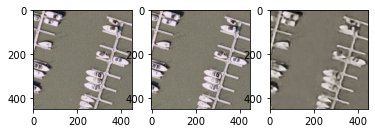

Orig  0.05724289889770548 0.9957983195781712
Gen  0.0 1.0


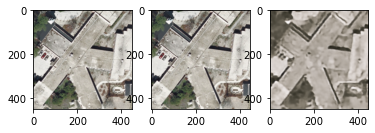

Orig  0.02675070105196558 1.0
Gen  0.0 1.0


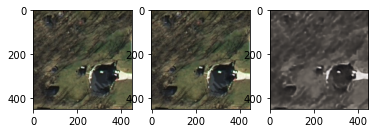

Orig  0.0470588244497776 0.9803921580314636
Gen  0.0 1.0


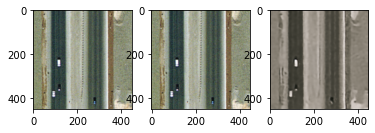

Orig  0.4082833187920703 0.8275110146829043
Gen  0.0 1.0


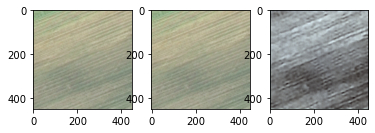

Orig  0.05684273893355651 0.9766106456518178
Gen  0.0 1.0


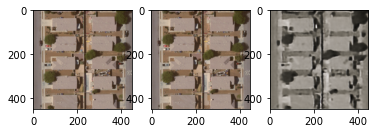

Orig  0.19761905180556522 0.6657863344464977
Gen  0.0 1.0


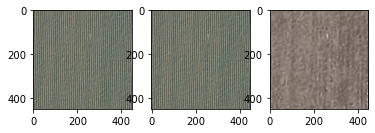

Orig  0.05104041686851757 0.9803921580314636
Gen  0.0 1.0


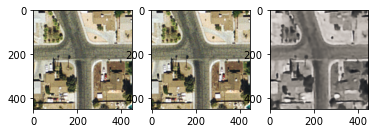

Orig  0.0117647061124444 0.9650460204907831
Gen  0.0 1.0


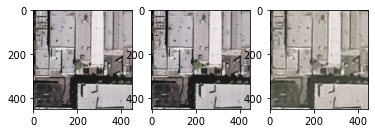

Orig  0.16716687168393848 0.9544017634221507
Gen  0.0 1.0


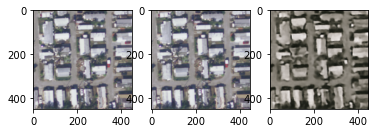

In [19]:

for i in range(10):
    index=np.random.randint(0,len(X_test_reshaped))

    X_test_im=np.expand_dims(X_test_reshaped[index],0)
    out_image=np.squeeze(model.predict(X_test_im))
    
    im_min=out_image.min(axis=(0, 1), keepdims=True)
    im_max=out_image.max(axis=(0, 1), keepdims=True)
    out_image=(out_image-im_min)/(im_max-im_min)
    
    
    print("Orig ",np.min(X_test_im),np.max(X_test_im))
    print("Gen ",np.min(out_image),np.max(out_image))
    fig=plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_reshaped[index])
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(X_test_im))
    plt.subplot(1,3,3)
    plt.imshow(out_image)
    plt.show()

## Modifying Loss Function

In [20]:
import tensorflow.keras.backend as K

def custom_loss(model,y_true, y_pred):
    with tensorflow.GradientTape(persistent=True) as tape:
        def loss(y_true,y_pred):
            y_true_hist=tf.histogram_fixed_width(y_true, value_range=(0., 1.), nbins=20) 
            y_pred_hist=tf.histogram_fixed_width( y_pred, value_range=(0., 1.), nbins=20) 
            return K.mean(K.square(y_true_hist-y_pred_hist))
        loss=loss(y_true,y_pred)
        return tape.gradient(loss,model.trainable_variables)

In [21]:
encoder_model=encoder(dims)
encoding_depth=15

decoder_model=decoder(encoder_model.output_shape[1:])

model=Sequential()
model.add(encoder_model)
model.add(decoder_model)

model.build(input_shape=(None,*dims))

model.compile(optimizer='rmsprop', loss=custom_loss)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 28, 28, 5)         9844215   
_________________________________________________________________
decoder (Sequential)         (None, 448, 448, 3)       1227435   
Total params: 11,071,650
Trainable params: 11,071,650
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(train_dataset,
                    epochs=50,
                    steps_per_epoch=len(X_train_reshaped)/batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(X_test_reshaped)/batch_size)

Epoch 1/50


TypeError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: custom_loss() missing 1 required positional argument: 'y_pred'


In [ ]:
model.save('../ssd/proxy_models/ae_epoch100_customloss_ucmerced')